# Processing, analysis, and visualization pipeline for event-related voltammetry data

## The goal of this pipeline is to find and quantify the largest distinguishable signal changes (peaks) following stimulus presentations in an experimental group and corresponding changes in a control group

In [ ]:
%pylab inline
%load_ext autoreload
%autoreload 2
import pynit as pn #to handle BIDS-style data organization
import pandas as pd
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import numpy as np
import scipy.fftpack
from sklearn.linear_model import LinearRegression
from pandas import DataFrame, date_range, datetime, read_csv
from matplotlib import pyplot, colors, rcParams 
from datetime import timedelta  
from scipy.signal import find_peaks, peak_prominences, peak_widths, find_peaks_cwt, butter, lfilter, freqz, sosfilt, welch, filtfilt, lfilter_zi, sosfilt_zi, sosfiltfilt
from numpy import NaN, asarray
from math import isnan
import seaborn as sns

rcParams['figure.dpi'] = 300
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Liberation Sans']

import warnings
warnings.filterwarnings("ignore")

# Plot formatting helper function

In [13]:
def tsplot(df, add_plot=None, figsize=None, xlim=None, ylim=None, xlabel=None, ylabel=None,
               label_size=None, tick_size=None, title=None, title_size=None, err=0, **kwargs):
        """

        :param df:
        :param figsize:
        :param xlim:
        :param ylim:
        :param xlabel:
        :param ylabel:
        :param label_size:
        :param tick_size:
        :param title:
        :param title_size:
        :param err: 0 = standard deviation, 1 = standard error
        :param kwargs:
        :return:
        """
        if not add_plot:
            fig, axes = plt.subplots(1,1,figsize=figsize)
        else:
            fig, axes = add_plot
        fig.patch.set_facecolor('white')
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)
        for axis in ['top','bottom','left','right']:
              axes.spines[axis].set_linewidth(5)
        if xlim:
            axes.set_xlim(xlim)
        if ylim:
            axes.set_ylim(ylim)
        if title:
            axes.set_title(title, size=title_size)
        if xlabel:
            axes.set_xlabel(xlabel, size=label_size)
        else:
            axes.set_xlabel('Time (s)', size=label_size)
        if ylabel:
            axes.set_ylabel(ylabel, size=label_size)
        else:
            axes.set_ylabel('Responses', size=label_size)
        tlen = int(tick_size/5)
        
        axes.tick_params(labelsize=tick_size, direction='out', top='off', right='off', width = 5, length = tlen)
        grey2 = [colors.to_rgba('grey',.1)]
        
        if err == 1:
            sns.tsplot(df.T.values, err_style='sterr_band', ax=axes,  **kwargs)
            
        elif err == 0:
            sns.tsplot(df.T.values, err_style=None, ax=axes, **kwargs)
        else:
            sns.tsplot(df.T.values, err_style='unit_traces', err_palette = grey2, err_kws = {'alpha':.15}, ax=axes, **kwargs)
        return fig, axes

# Optional function to convert continuous event-related time series data with regular stimulus presentations/ trials into seperate columns for each trial
## This is the format expected by the pipeline

In [31]:
import os
import pandas as pd
from pandas import read_excel, DataFrame
def cut_excel(infile, outfolder, ses, trialend):
    session = read_excel(infile, index= None, header= None)
    session = session.dropna(axis= 1, how='all')
    for name in session.columns:
        trial = session[name].tolist();
        trial = DataFrame(data=trial)
        trial.columns = ['name-for-data-source'] #enter the name you want as a column header for the data
        trial[0:trialend].to_excel('{}/{}_{}'.format(outfolder, name, ses), index=None, header='name-of-data-source)

In [55]:
infolder = '/home/your-raw-data-folder' #enter the directory for your data folder, this should be one level below the folders for each group containing your files
trialend = 400 #set this to length of each trial in continuous recording
for grp in os.listdir(infolder):
    grpfolder = os.path.join(infolder, grp)
    if os.path.isdir(grpfolder):
        outfolder = os.path.join(infolder, 'cut_'+grp)
        try:
            os.mkdir(outfolder)
        except:
            pass
        for ses in os.listdir(grpfolder):
            infile = os.path.join(grpfolder, ses)
            cut_excel(infile, outfolder, ses, trialend)

# load BIDS format project object from parent directory
## This should point to project in a \project\subproject\group\dtype\ directory organization

In [ ]:
prj = pn.Project('/home/user/project') 
prj.reload() # reload all updates
prj(2, ext=['.xlsx']).summary

# function to get group-level data from project object
## in this version, dtype is seperated by columns, not the highest folder level

In [6]:
def get_volt_from_group(prj, session, group, dtype):
    new_prj = prj(2, 'my-main-project-folder-name', session, group, ignore=['Contra'], ext='.xlsx') #enter your project information here
    df = pd.DataFrame()
    for i, finfo in new_prj:
        df[i] = pd.read_excel(finfo.Abspath)[dtype]
       #     df=df.iloc[:] #use this if needed to truncate files that might have extra time points
    return df

# function to correct baseline drift by subtracting OLS line of best fit

In [15]:
def flatten_data(y):
    for name in y.columns:
        X = np.array(range(len(y[name]))).reshape(-1,1)
        Y = y[name].values.reshape(-1,1)
        lr = LinearRegression().fit(X, Y)  # perform linear regression


        slope = lr.coef_[0][0]
        y_int = lr.intercept_[0]

        for i in range(len(y[name])):
            y[name][i] = y[name][i] - (slope * i + y_int)

# function to baseline correct, baseline substract, convert molar units, and plot data (mean +/- SEM) for 2 groups relative to stimulus timing and export to excel

## Change veriables to fit your paradigm as needed here or when calling function

In [7]:
def plot_volt_data(prj, session, opto_group_a, eyfp_group_a, region, units= 1, figsize=[7.5,7.5], label_size=60, err=1, title_size=60, 
                    tick_size=50, ylabel= "Dopamine (" + u'\u03BC'+"M)", xlabel='', color1='tab:red', color2='tab:grey',
                    bl_end=99, n_tick_b=100, stim=[[100],100], linewidth = 5, ylim=None, n_tick_a = None):

    data_opto_a = get_volt_from_group(prj, session, opto_group_a, region)
    data_opto_raw = get_volt_from_group(prj, session, opto_group_a, region)
    flatten_data(data_opto_a)

    dfup_sub = data_opto_a.iloc[0:bl_end]

   
    data_opto_a = data_opto_a - dfup_sub.mean()
    data_opto_a = data_opto_a*units
       
    data_eyfp_a = get_volt_from_group(prj, session, eyfp_group_a, region)
    data_eyfp_raw = get_volt_from_group(prj, session, eyfp_group_a, region)
    flatten_data(data_eyfp_a)

    dfup_sube = data_eyfp_a.iloc[0:bl_end]
                                
    data_eyfp_a = data_eyfp_a - dfup_sube.mean()
    data_eyfp_a = data_eyfp_a*units
    
    data_opto_a.to_excel('{}_{}_{}.xlsx'.format(session, opto_group_a, region), index=None, header=None)
    data_eyfp_a.to_excel('{}_{}_{}.xlsx'.format(session, eyfp_group_a, region), index=None, header=None)
    
    print 'Data from:'+ data_opto_a.shape[1] + opto_group_a + 'trials and' + data_eyfp_a.shape[1] + 'trials'
        
    ax = tsplot(data_eyfp_a, color = color2, ylim = ylim, err=err, figsize=figsize,label_size=label_size,
                title_size=title_size, tick_size=tick_size, ylabel=ylabel, xlabel=xlabel, linewidth=linewidth)
    ax = tsplot(data_opto_a, color = color1, ylim = ylim, err=err, figsize=figsize,label_size=label_size,
                title_size=title_size, tick_size=tick_size, ylabel=ylabel, xlabel=xlabel, linewidth=linewidth, add_plot=ax)
    ax[1].yaxis.set_major_locator(ticker.MultipleLocator(n_tick_a))
    ax[1].set_xlim(right = data_opto_a.shape[0])
    ax[1].xaxis.set_major_locator(ticker.MultipleLocator(n_tick_b))
    ax[1].xaxis.set_major_formatter(FuncFormatter(numfmt))
    ylim_neg = ax[1].get_ylim()
    if stim:
        for p in stim[0]:
            ax[1].add_patch(patches.Rectangle((p, ylim_neg[0]), stim[1], abs(ylim_neg[0])+abs(ylim_neg[1]),color='g', alpha=0.09))
    
    return ax

# Optional function to convert x axis timeseries units

In [8]:
def numfmt(x, pos): # custom formatter function
    s = '{:.0f}'.format((x-100) / 10.0)  #first value is event onset, second is temporal resolution (Hz)
    return s

61
61


(<matplotlib.figure.Figure at 0x7fe70c974c10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe712508450>)

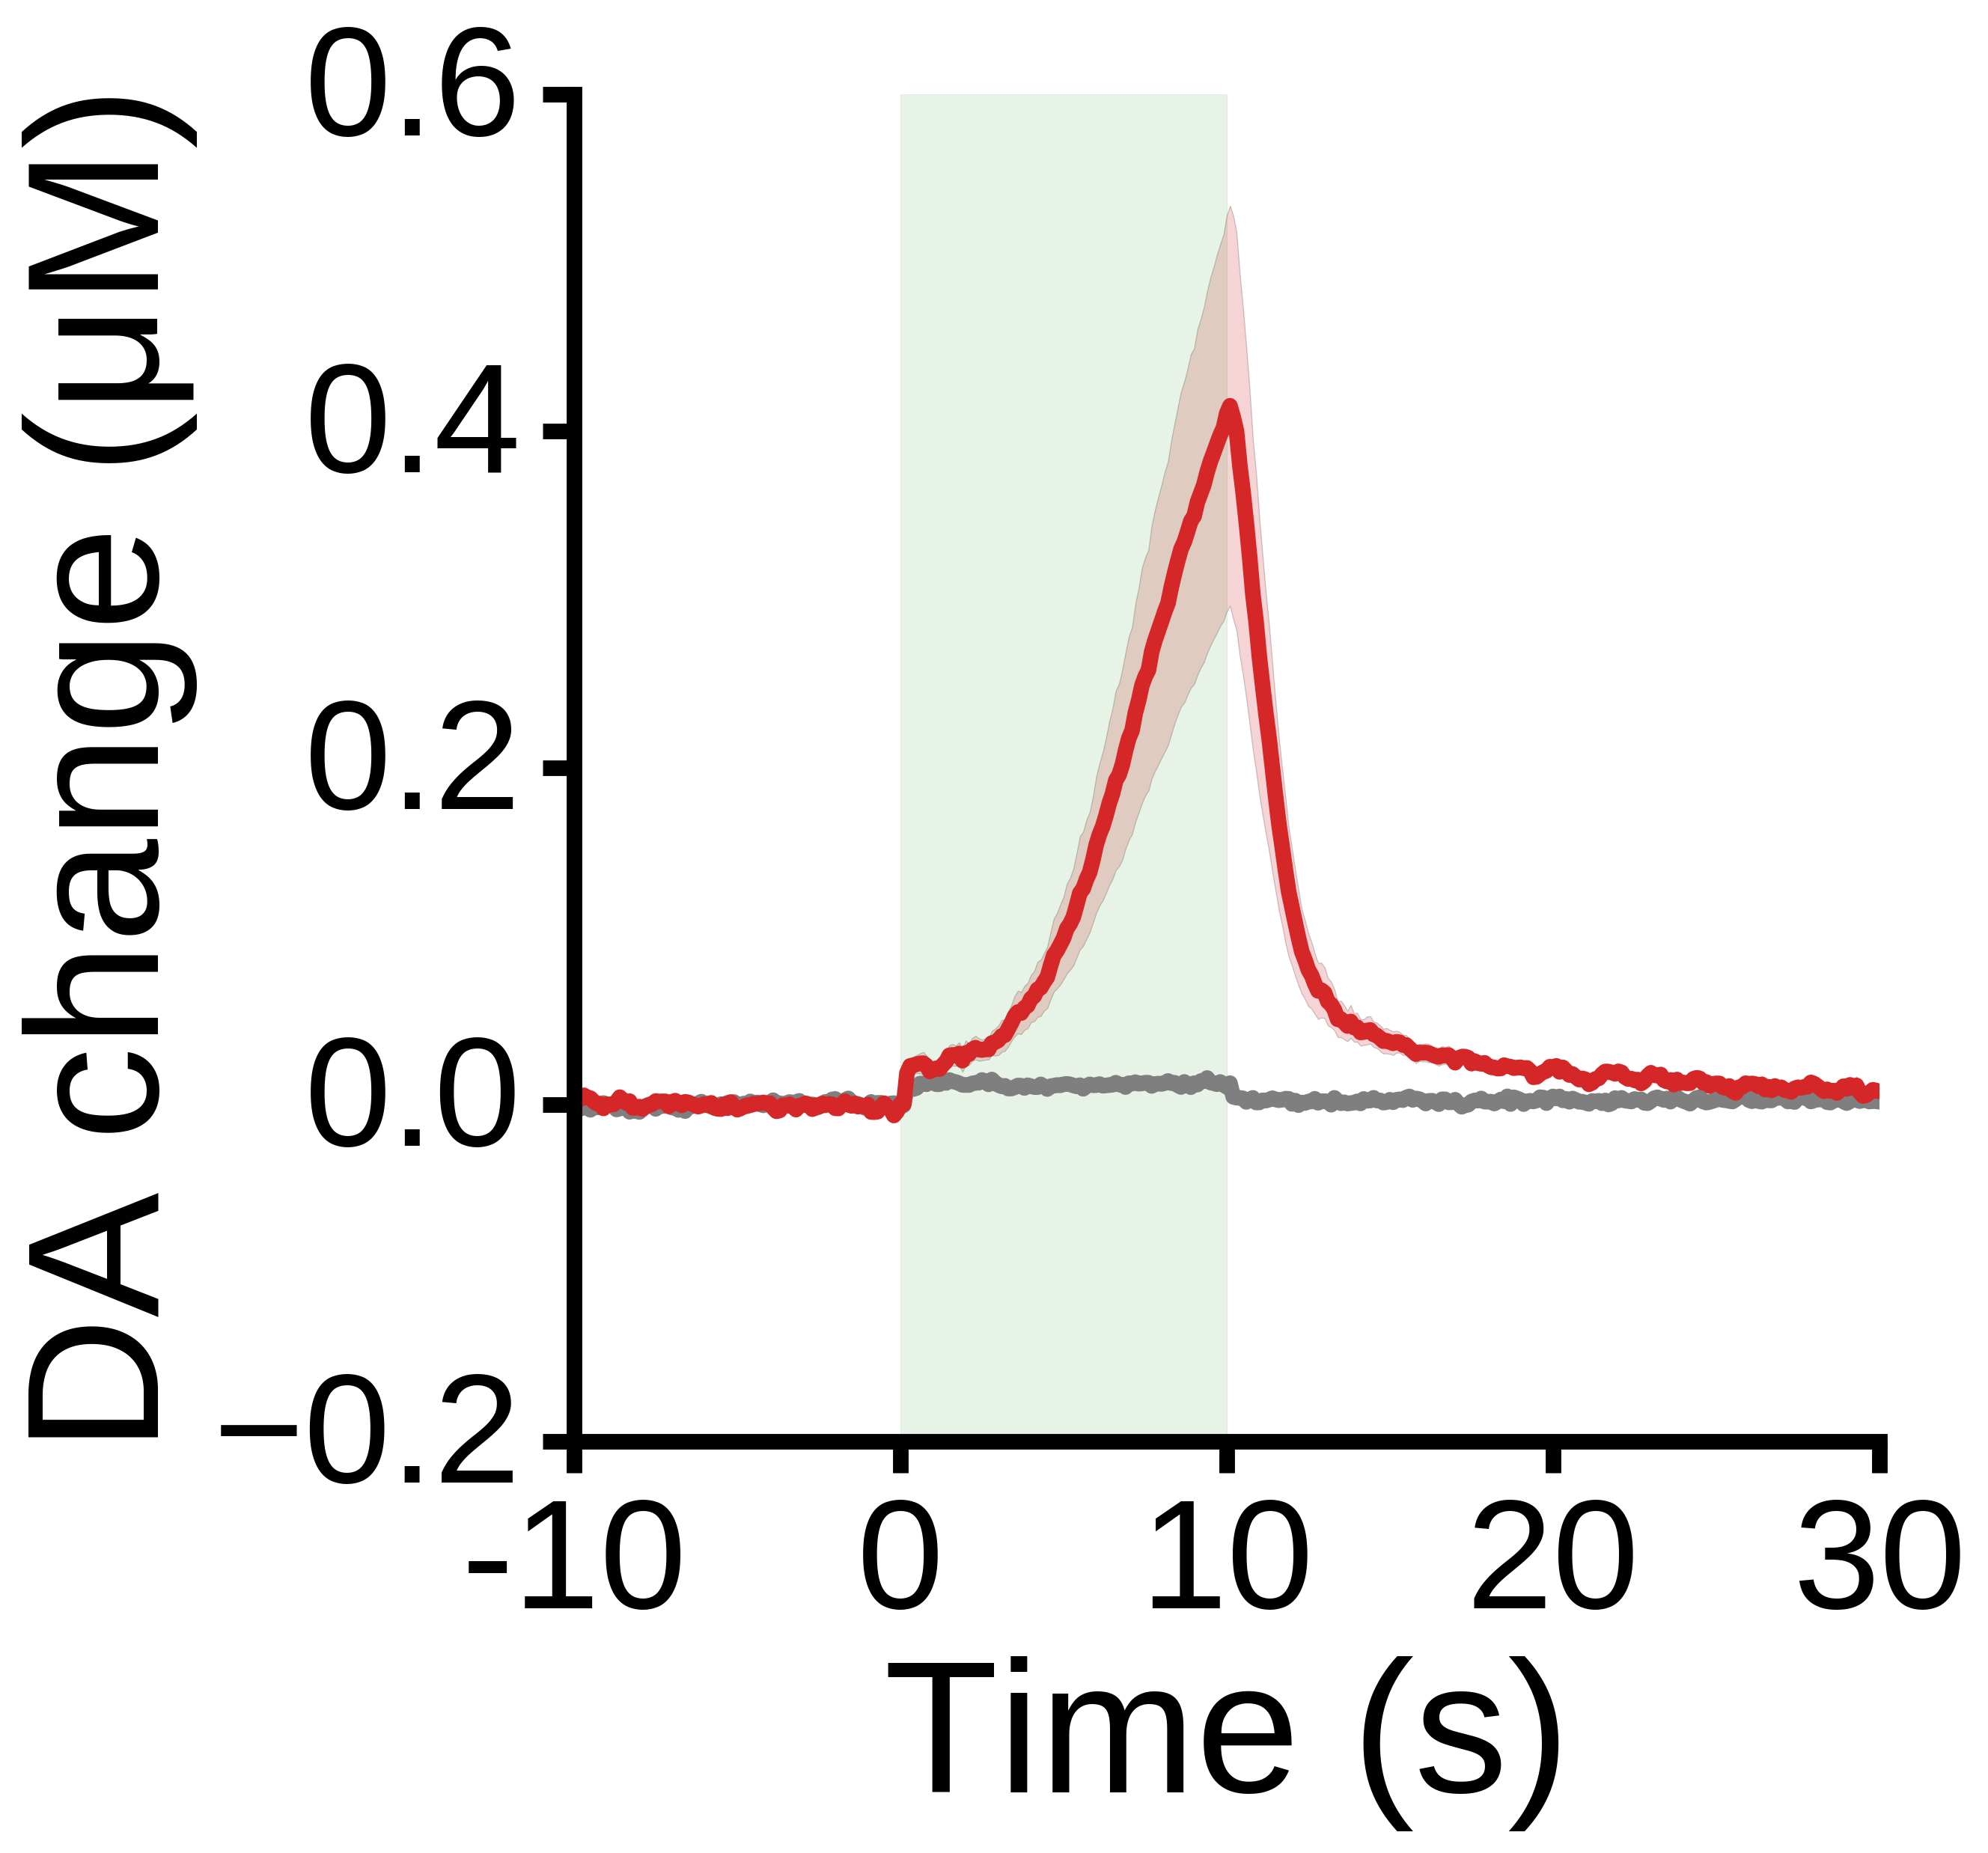

In [29]:
## be sure to define the subproject, groups, and dataype before executing
plot_volt_data(prj,'subproject-name', 'first_group', 'second_group' , 'dtype', color1 = 'tab:red', n_tick_a = .2, ylim = [-.2,.6],
               ylabel= "DA change (" + u'\u03BC'+"M)")

# Additional function to find the location of the largest peak following stimulus presentation on the group level, then extract the value at that location for each trial, plot these peaks and export the data to excel

## note that most parameters should be set when calling the function. Group to analyze peak location is always taken from the first_group (experimental)

In [16]:
def analyze_volt(prj, session, analyze_group, opto_group, region, sign, stim_start, stim_end, avg_start, avg_end, units = 1):
    
    data_opto = get_volt_from_group(prj, session, analyze_group, region)
    flatten_data(data_opto)

    dfup_sub = data_opto.iloc[0:stim_start-2]
    data_opto = data_opto - dfup_sub.mean()
    data_opto = data_opto*units
        
    data_ChR2 = get_volt_from_group(prj, session, opto_group, region)
    flatten_data(data_ChR2)
    dfup_ChR2 = data_ChR2.iloc[0:stim_start-2]
    data_ChR2 = data_ChR2 - dfup_ChR2.mean()
    df_ChR2 = data_ChR2*sign*units
    
    dmean = df_ChR2.mean(axis=1)
    dmean = pd.DataFrame(dmean)
    dmean = dmean[0].tolist()
    peakloc = dmean.index(max(dmean[stim_start:stim_end]))
    
    dfup = data_opto
    
    ax = dfup.plot(cmap='summer',legend=False, figsize= (9,9), linewidth=0.5)
    ax.set_prop_cycle(pyplot.rcParams["axes.prop_cycle"])
    newdf = DataFrame()
    
    csvdf = DataFrame(data=None, columns=['Name','PeakX', 'PeakY'])
    
    styles = {}
    count=0
    for name in dfup.columns:
        list = dfup[name].tolist();
               
        peakx=peakloc
        peaky=sum(list[peakloc+avg_start:peakloc+avg_end]) / len(list[peakloc+avg_start:peakloc+avg_end])
        
        newcol = []
        newcol = newcol + [NaN]*(dfup.count()[0]);
        
        newcol[peakx] = peaky

        newdf[int(name)] = newcol
        csvdf = csvdf.append({'Name':name, 'PeakX': peakx, 'PeakY':peaky}, ignore_index=True);

    csvdf.to_csv('{}_{}_{}.csv'.format(session, analyse_group, region))
    a = newdf.plot(marker= 7, color='black', legend=False, ax=ax)
    ax.add_patch(patches.Rectangle((peakloc+avg_start-0.5,-100),avg_end-avg_start+1, 200, color='b', alpha=.09))
    pyplot.show()

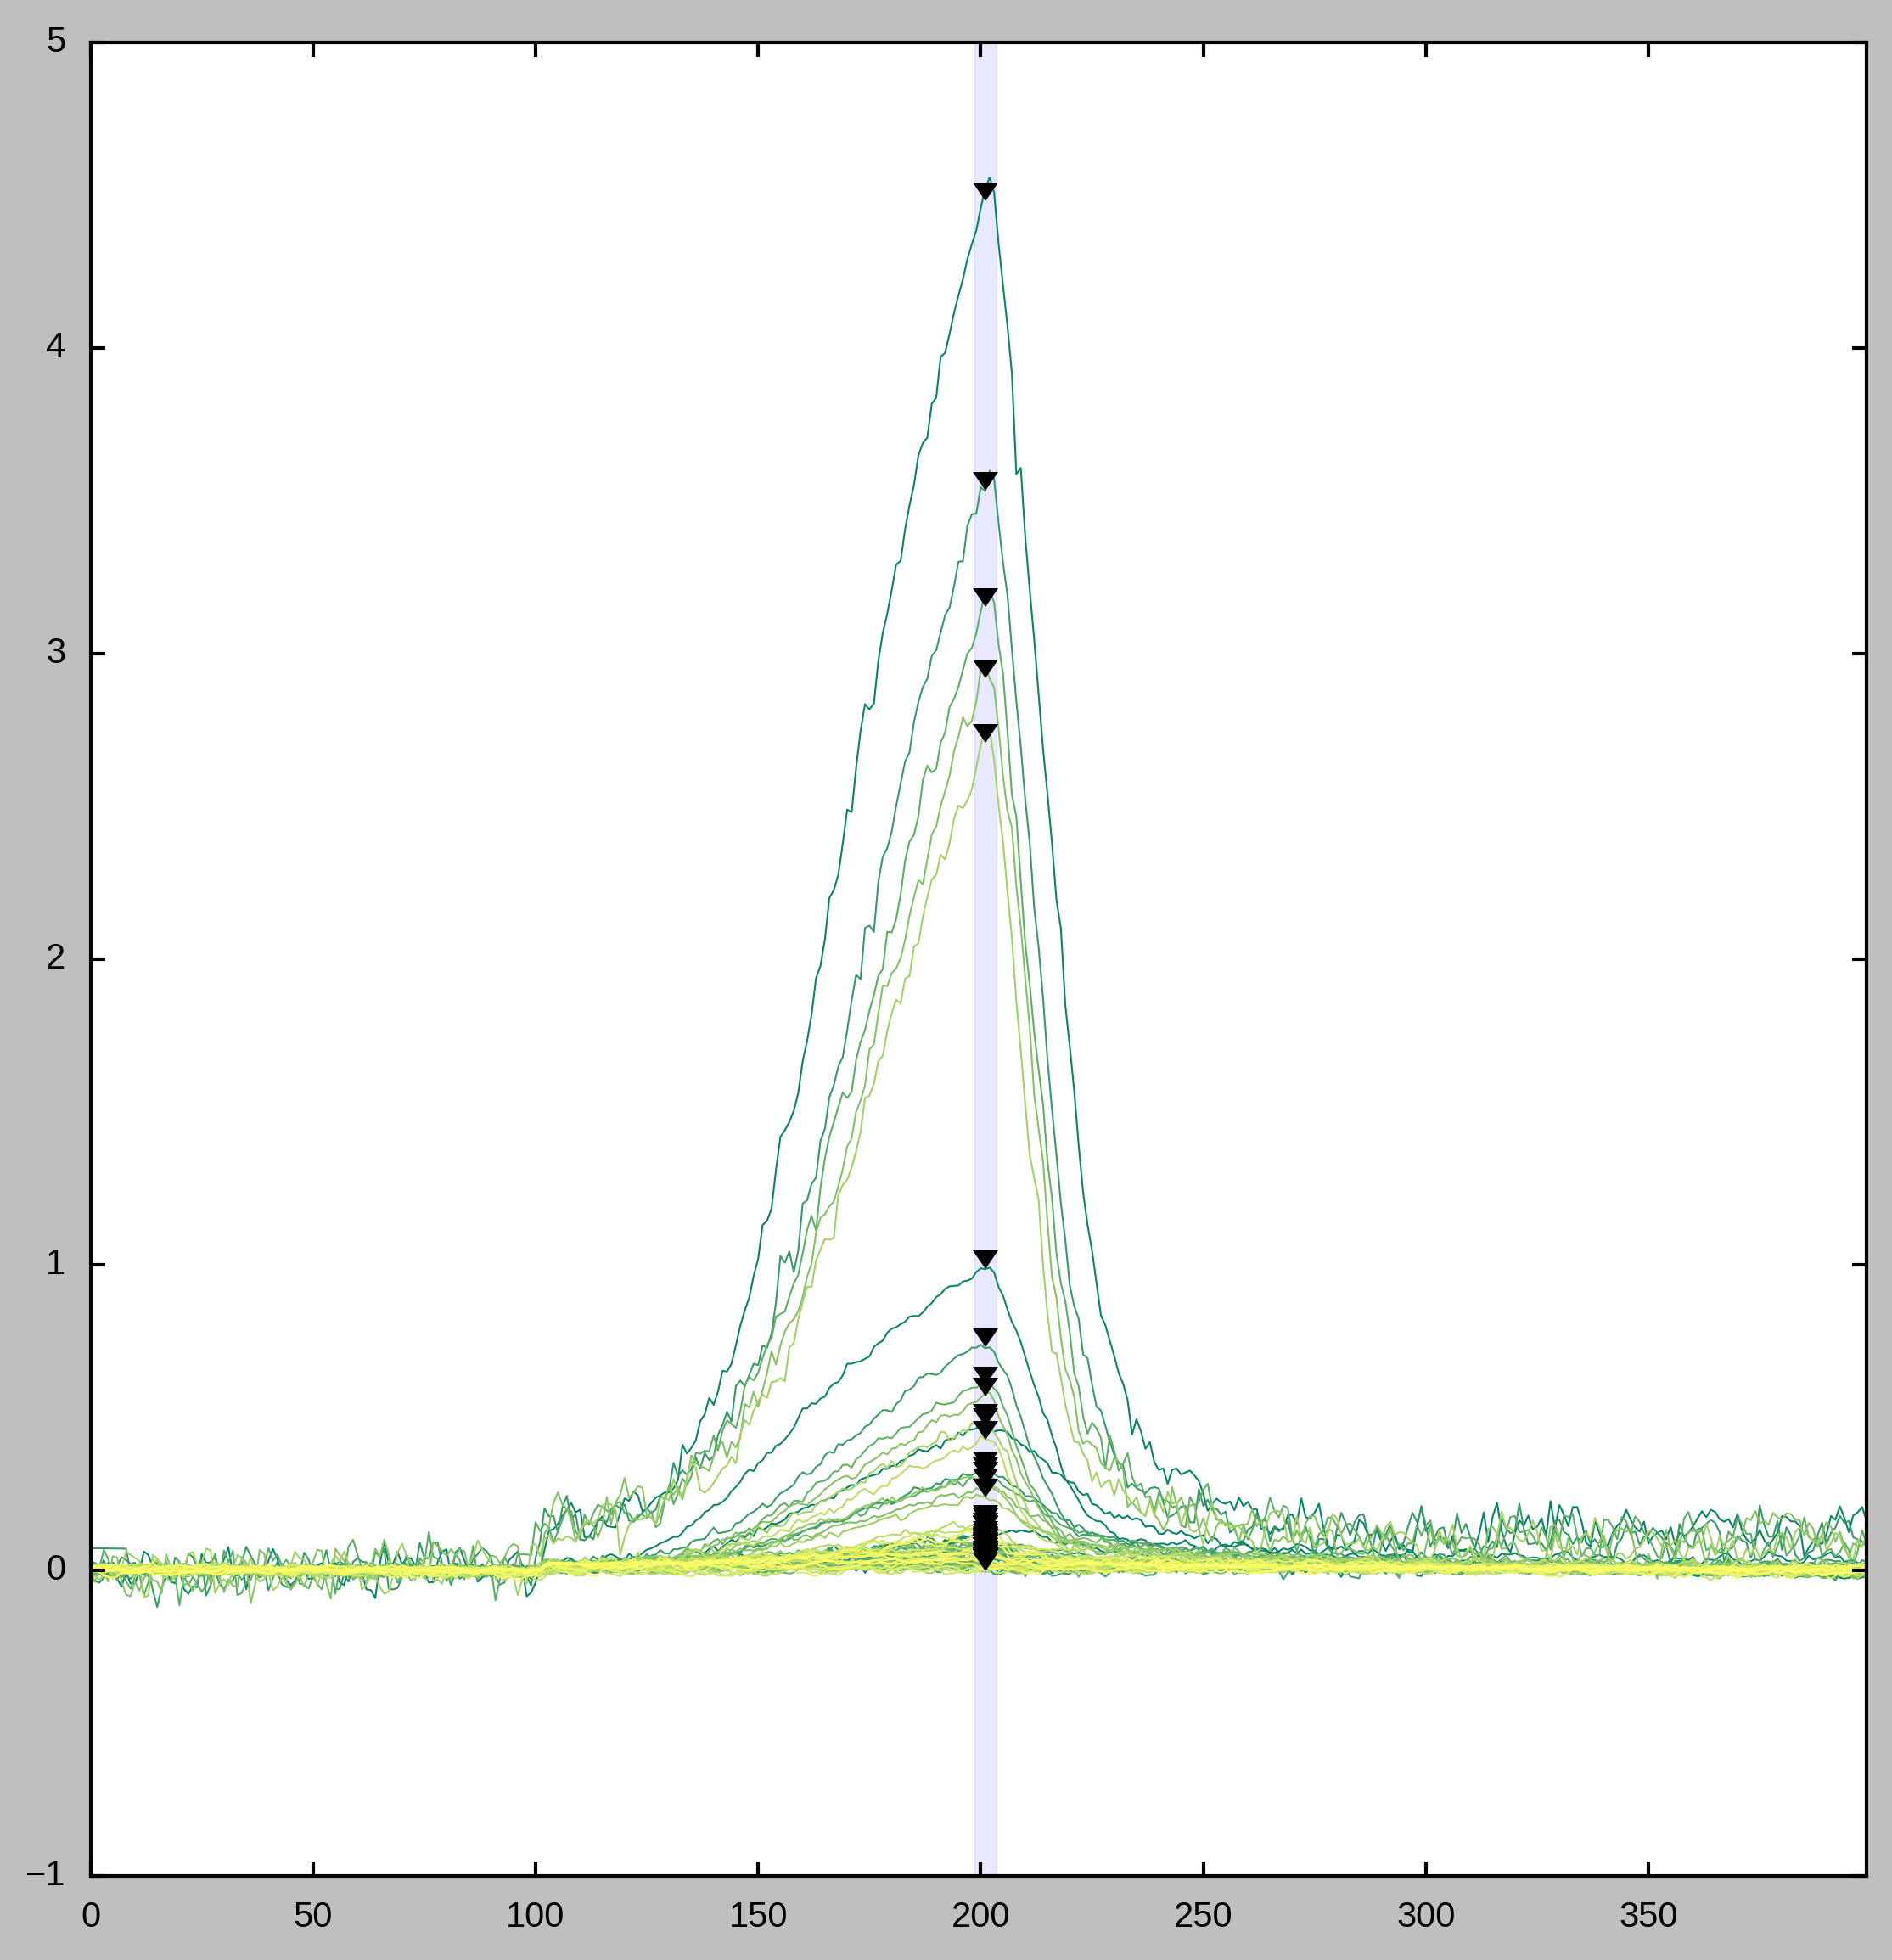

In [21]:
analyze_volt(prj, 'subproject-folder-name', 'to-analyze-group-name','first-group-name', 'dtype-column-name', sign = 1, stim_start = 101, stim_end = 250, avg_start = -2, avg_end = 2)

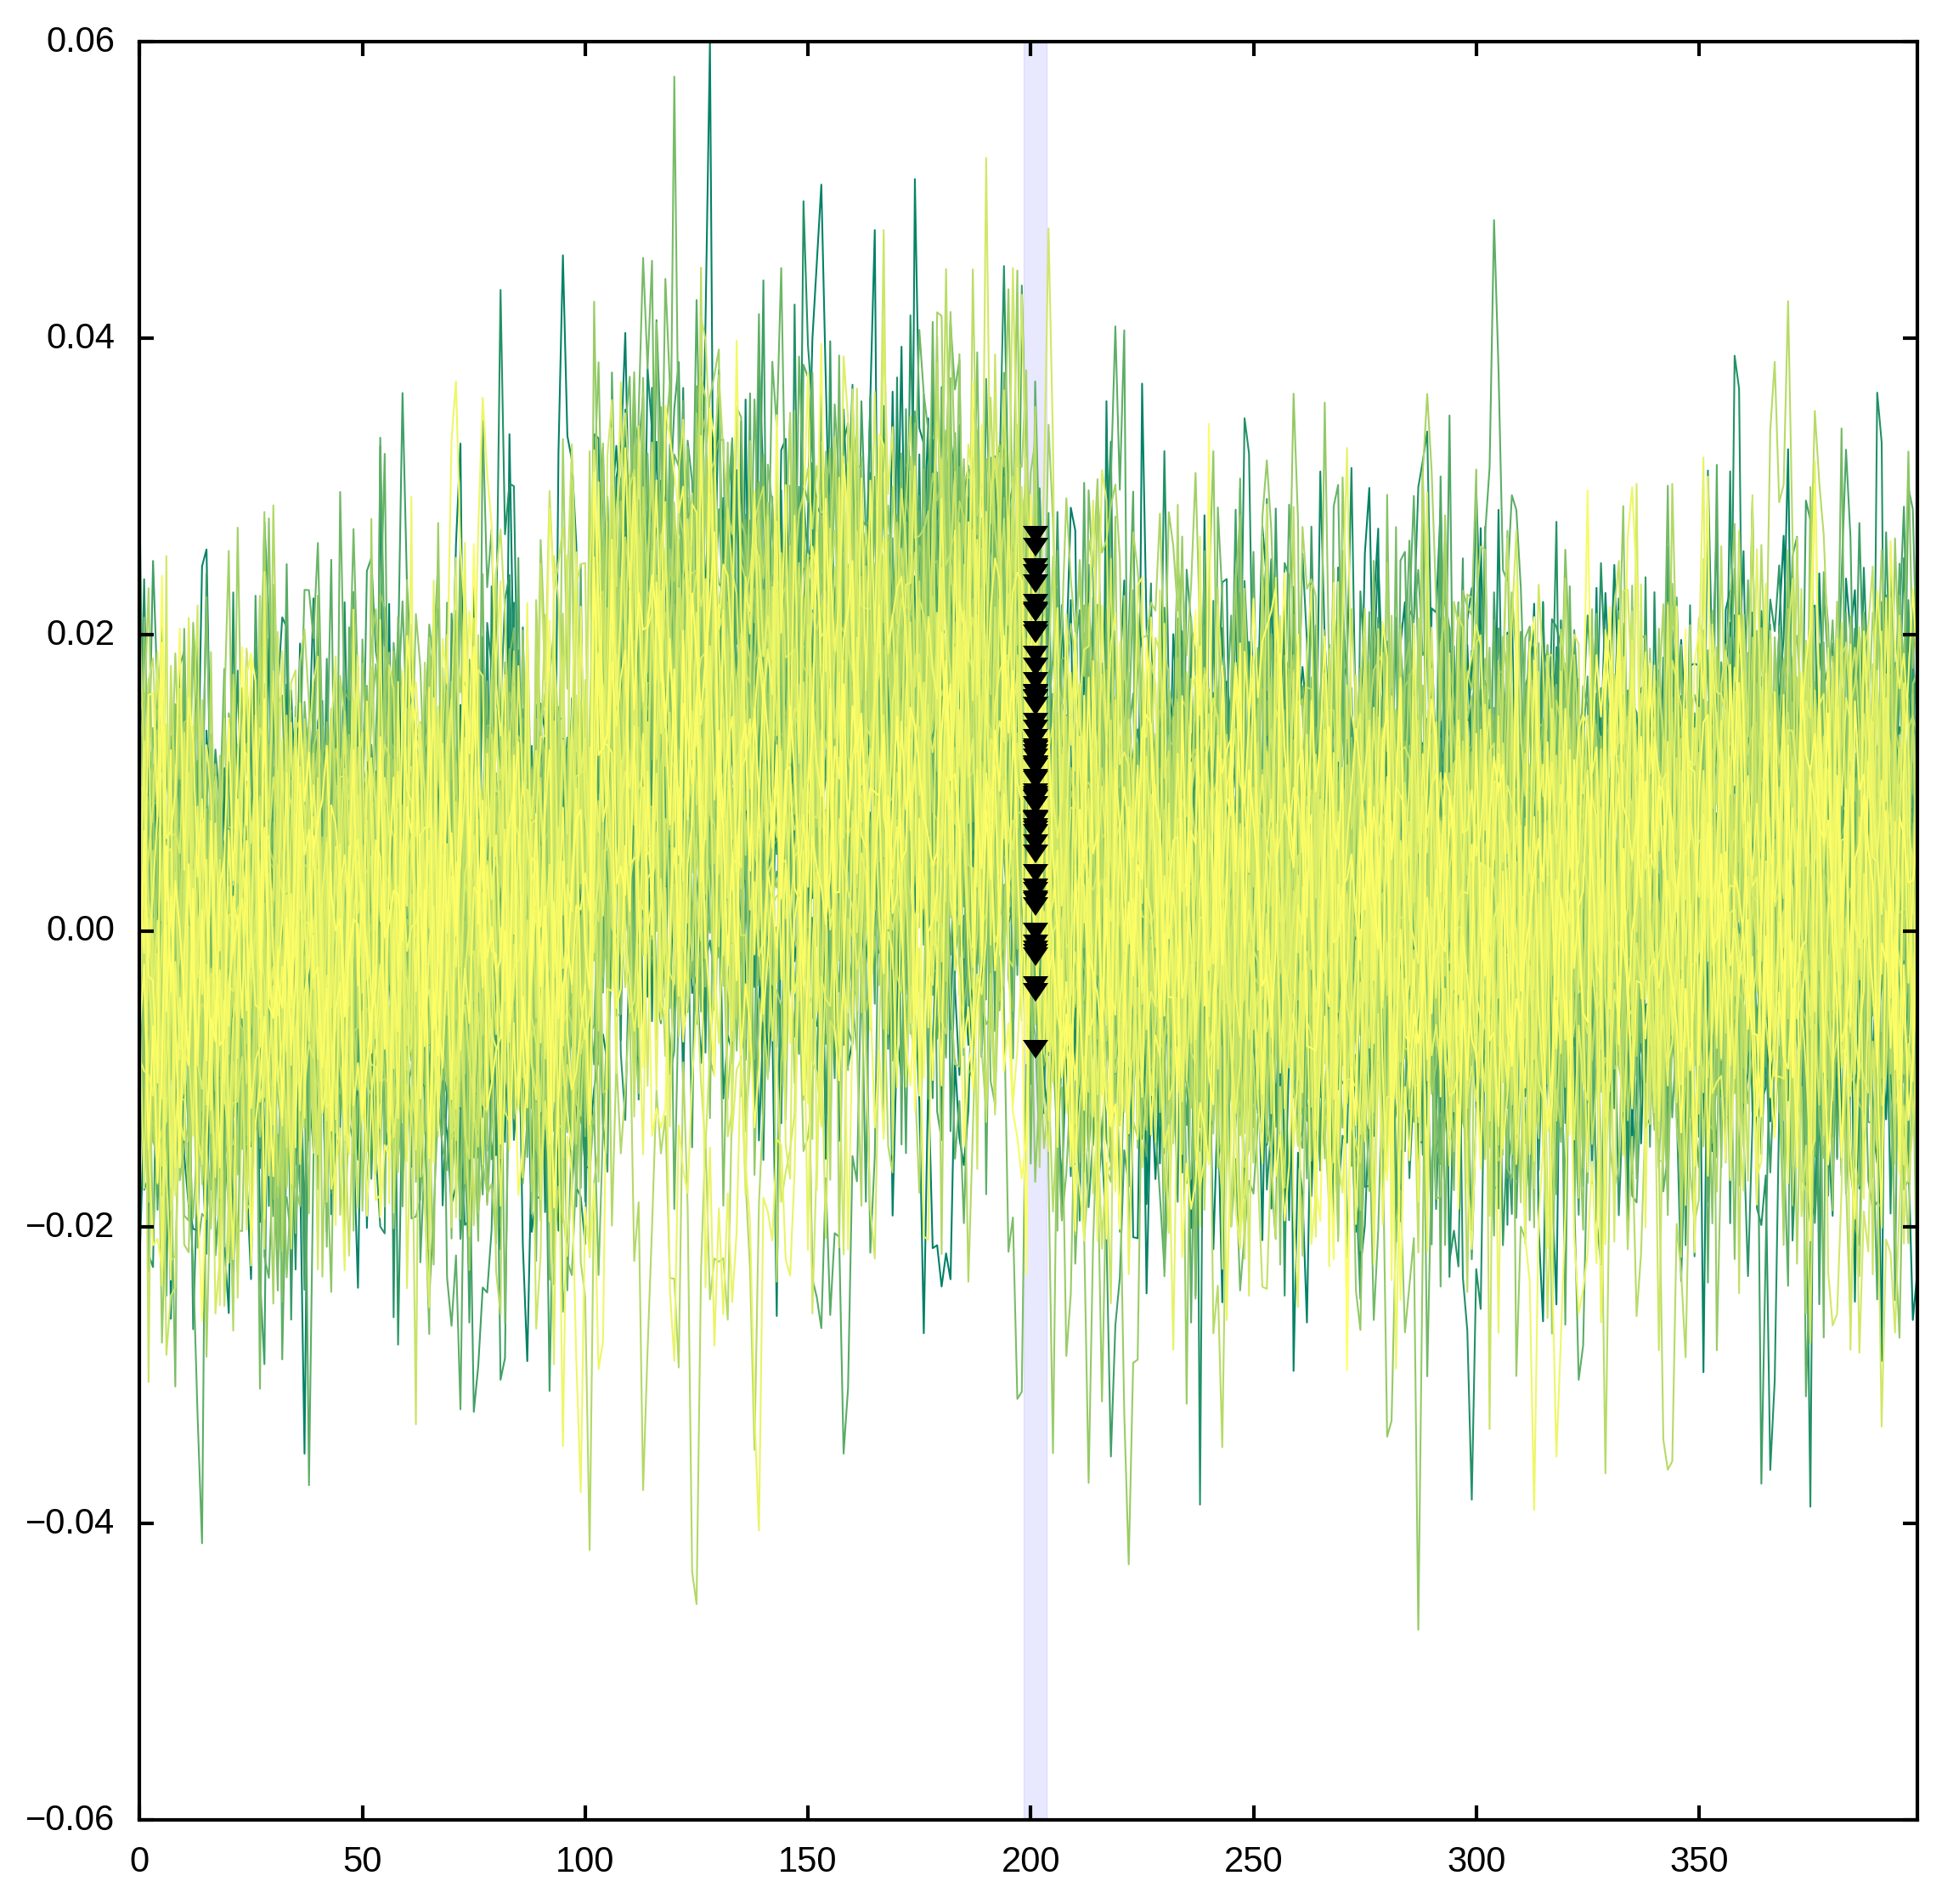

In [28]:
analyze_volt(prj, 'subproject-folder-name', 'to-analyze-group-name','first-group-name', 'dtype-column-name', sign = 1, stim_start = 101, stim_end = 250, avg_start = -2, avg_end = 2)